# Preview

In this example, we are going to use our toolbox to train and evaluate the [Trajectory-based Dynamics Model](https://arxiv.org/abs/2012.09156) in the reacher environment. Note that the reacher environment in this repository is slightly different than the one used in that paper ([link](https://github.com/natolambert/continuousprediction/blob/master/envs/reacher3d.py))!

## Conceptual Overview

The *Trajectory-based Model* is a alternate type of dynamics model designed for applicatons of model-based reinforcement learning (MBRL) where one would prioritize long-term prediction accuracy (and overcome the well-known [compounding error](http://arxiv.org/abs/2203.09637). This is accomplished by moving away from the standard one-step parametrization of a dynamics model in MBRL.

As a review, state-predictions are often done in a **one-step** manner in MBRL:

$$s_{t+1} = f_\theta(s_t,a_t),$$

where $s_t$ is the state of the environment, $a_t$ is the action taken by the agent, and $f_\theta(\cdot)$ is a learned model of the world.
A common issue is that the long-term future is predicted with recursive function calls, which is known to lead to compounding error:

$$s_{t+h}=f_\theta(\ldots f_\theta(f_\theta(s_t,a_t),a_{t+1}) \ldots , a_{t+h}).$$

As an alternate, the trajectory-based model predicts a direct time horizon in the future $h$. In order to avoid needing to pass in every action to the model, it takes in the control parameters that would define the policy $a_t = \pi_\phi()$, understanding that the sequence of actions are often highly correlated. This yields a new formulation as follows:

$$s_{t+h} = f_\theta(s_t, h, \phi).$$

This model confers a series of benefits on top of long-term prediction accuracy, including stable uncertainty propagation, fast inference (no more recusion -- just pass in a vector of time), and better sample efficiency.

In this notebook, we show you how the model can be trained almost entirely on built in MBRL-Lib code!

-----

# Setup
In this section we import the needed code from MBRL-Lib, create the environment, and configure our experiment.

## Imports

In [1]:

%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import omegaconf
import torch

import mbrl.env.pets_reacher as reacher_env
import mbrl.env.termination_fns as termination_fns
import mbrl.models as models
import mbrl.util.common as common_util
from mbrl.planning import Agent


%load_ext autoreload
%autoreload 2

mpl.rcParams.update({"font.size": 16})

device = 'cuda:0' if torch.cuda.is_available() else 'cpu'

## Creating the environment

First we instantiate the environment.

In [2]:
seed = 0

env = reacher_env.Reacher3DEnv()
env.reset(seed = seed) # env.seed() is not available for this environment, seems to be reset() instead

# experiment constants
trial_length = 500
num_trials = 10

# constants and random number generation
generator = torch.Generator(device=device)
generator.manual_seed(seed)

obs_shape = env.observation_space.shape
act_shape = env.action_space.shape

print(f"Observation shape: {obs_shape}, action shape: {act_shape}")

Observation shape: (19,), action shape: (7,)


## PID Agent

In this section we add a basic PID agent to the library to use as the control parameters for prediction with the new model.

In [3]:
class PIDAgent(Agent):
    """
    Agent that reacts via an internal set of PID controllers.
    """

    def __init__(
        self,
        dim: int,
        Kp: np.ndarray,
        Ki: np.ndarray,
        Kd: np.ndarray,
        target: np.ndarray,
    ):
        super().__init__()
        assert len(Kp) == dim
        assert len(Ki) == dim
        assert len(Kd) == dim
        assert len(target) == dim

        self.n_dof = dim

        # TODO: add helper functions for setting and using state_mapping
        self.state_mapping = None   # can set to run PID on specific variables

        self.Kp = Kp
        self.Ki = Ki
        self.Kd = Kd
        self.target = target
        self.prev_error = 0
        self.error = 0

    def act(self, obs: np.array) -> np.ndarray:
        # in fact, the DOF limits the observation to be 7, original obs is 19 length
        if len(obs) > self.n_dof:
            obs = obs[:self.n_dof]
        q_des = self.target
        q = obs

        self.error = q_des - q
        P_value = self.Kp * self.error
        I_value = 0  # TODO: implement I and D part
        D_value = self.Kd * (self.error - self.prev_error)
        self.prev_error = self.error
        action = P_value + I_value + D_value
        return action

    def _get_P(self):
        return self.Kp

    def _get_I(self):
        return self.Ki

    def _get_D(self):
        return self.Kd

    def _get_targets(self):
        return self.target

    def get_parameters(self):
        return np.stack((self._get_P(), self._get_I(), self._get_D(), self._get_targets())).flatten()


def create_pid_agent(action_dim, obs_dim):
    # default is to create a PD controller on the joints of the reacher robot
    P = np.random.rand(action_dim) * 5
    I = np.zeros(action_dim)
    D = np.random.rand(action_dim)

    # sample joint angle targets for the end-affector of the reacher
    target = np.random.rand(action_dim) * 2 - 1 #np.random.rand(obs_dim) #

    agent = PIDAgent(dim=action_dim, Kp=P, Ki=I, Kd=D, target=target)
    return agent

Now we can create an agent by just loading information about the action space from the environment!

In [4]:
agent = create_pid_agent(env.action_space.shape[0], env.observation_space.shape[0])

The agent determines the dimension of the input for trajectory-based model.

In [5]:
param_shape = (len(agent.get_parameters())+1,)
print(f"Parameter shape: {param_shape}")
print(f"Parameter values: {agent.get_parameters()}")

Parameter shape: (29,)
Parameter values: [ 2.16767158  1.64957444  3.67602429  1.80903658  3.3674832   1.50399711
  3.36366877  0.          0.          0.          0.          0.
  0.          0.          0.65251843  0.65959842  0.75812489  0.00977948
  0.75258702  0.51129136  0.89824264  0.95604133 -0.16567601  0.07237071
  0.81716387 -0.77658082 -0.33338755  0.1036919 ]


## Hydra configurations

MBRL-Lib uses [Hydra](https://github.com/facebookresearch/hydra) to manage configurations. For the purpose of this example, you can think of the configuration object as a dictionary with key/value pairs--and equivalent attributes--that specify the model and algorithmic options. Our toolbox expects the configuration object to be organized as follows:

### Trajectory-based model config
We define the trajectory-based model a little differently than the other examples in this library! You can see we are mapping the parameters in where the actions would normally go in the model.
Additionally, the `"propagation_method"` argument is redundant because we can predict entire trajectories with one forward pass!
The trajectory-based model tends to like bigger batch sizes than one-step models.

Finally, there are some constants that we keep constant with the one-step model too!

In [6]:
ensemble_size = 5
num_layers = 3
hid_size = 200
deterministic = False

# Everything with "???" indicates an option with a missing value.
# Our utility functions will fill in these details using the
# environment information
cfg_dict = {
    # dynamics model configuration
    "dynamics_model": {
        "_target_": "mbrl.models.GaussianMLP",
        "device": device,
        "num_layers": num_layers,
        "ensemble_size": ensemble_size,
        "hid_size": hid_size,
        "in_size": param_shape[0]+obs_shape[0], # control params, horizon, state_0
        "out_size": obs_shape[0],               # state time 0+h
        "deterministic": deterministic,
        "propagation_method": "random_model",# NOTE not currently used (predicted in one forward pass, no re-samplign)
        # can also configure activation function for GaussianMLP
        "activation_fn_cfg": {
            "_target_": "torch.nn.LeakyReLU",
            "negative_slope": 0.01
        }
    },
    # options for training the dynamics model
    "algorithm": {
        "learned_rewards": False,
        "target_is_delta": False, # trajectory based model predicts states directly
        "normalize": True,
    },
    # these are experiment specific options
    "overrides": {
        "trial_length": trial_length,
        "num_steps": num_trials * trial_length,
        "model_batch_size": 256,  # traj based model uses larger batch sizes
        "validation_ratio": 0.1
    }
}
cfg = omegaconf.OmegaConf.create(cfg_dict)

print(cfg)

{'dynamics_model': {'_target_': 'mbrl.models.GaussianMLP', 'device': 'cuda:0', 'num_layers': 3, 'ensemble_size': 5, 'hid_size': 200, 'in_size': 48, 'out_size': 19, 'deterministic': False, 'propagation_method': 'random_model', 'activation_fn_cfg': {'_target_': 'torch.nn.LeakyReLU', 'negative_slope': 0.01}}, 'algorithm': {'learned_rewards': False, 'target_is_delta': False, 'normalize': True}, 'overrides': {'trial_length': 500, 'num_steps': 5000, 'model_batch_size': 256, 'validation_ratio': 0.1}}


### One-step model config
We train a one-step model as a baseline against the trajectory-based model!

In [7]:
one_step_config_dict = {
    # dynamics model configuration
    "dynamics_model": {
        "_target_": "mbrl.models.GaussianMLP",
        "device": device,
        "num_layers": num_layers,
        "ensemble_size": ensemble_size,
        "hid_size": hid_size,
        "in_size": "???",
        "out_size": "???",
        "deterministic": deterministic,
#         "propagation_method": "random_model",
        "propagation_method": "expectation",
        # can also configure activation function for GaussianMLP
        "activation_fn_cfg": {
            "_target_": "torch.nn.LeakyReLU",
            "negative_slope": 0.01
        }
    },
    # options for training the dynamics model
    "algorithm": {
        "learned_rewards": False,
        "target_is_delta": True,
        "normalize": True,
    },
    # these are experiment specific options
    "overrides": {
        "trial_length": trial_length,
        "num_steps": num_trials * trial_length,
        "model_batch_size": 40,
        "validation_ratio": 0.1
    }
}

one_step_config = omegaconf.OmegaConf.create(one_step_config_dict)

----

# Experimentation

## Creating a dynamics model

Given the configuration above, the following two lines of code create a wrapper for 1-D transition reward models, and a gym-like environment that wraps it, which we can use for simulating the real environment. The 1-D model wrapper takes care of creating input/output data tensors to the underlying NN model (by concatenating observations, actions and rewards appropriately), normalizing the input data to the model, and other data processing tasks (e.g., converting observation targets to deltas with respect to the input observation).

In [8]:
# Create a 1-D dynamics model for this environment
dynamics_model = common_util.create_one_dim_tr_model(cfg, obs_shape, act_shape)
print(dynamics_model)

OneDTransitionRewardModel(
  (model): GaussianMLP(
    (hidden_layers): Sequential(
      (0): Sequential(
        (0): EnsembleLinearLayer(num_members=5, in_size=48, out_size=200, bias=True)
        (1): LeakyReLU(negative_slope=0.01)
      )
      (1): Sequential(
        (0): EnsembleLinearLayer(num_members=5, in_size=200, out_size=200, bias=True)
        (1): LeakyReLU(negative_slope=0.01)
      )
      (2): Sequential(
        (0): EnsembleLinearLayer(num_members=5, in_size=200, out_size=200, bias=True)
        (1): LeakyReLU(negative_slope=0.01)
      )
    )
    (mean_and_logvar): EnsembleLinearLayer(num_members=5, in_size=200, out_size=38, bias=True)
  )
)


## Create replay buffers

We can create a replay buffer for this environment using an configuration a built-in method, where `collect_trajectories` is on for easier plotting of results.

Please note, we will create three replay buffers because our use-case pushes the limits of mbrl-lib.
1. `replay_buffer_traj_train` is a replay buffer where will put all the sub-trajectories used to train the trajectory-based model,
2. `replay_buffer_traj_val` is a replay buffer storing trajectories with control parameters, used for plotting only.
3. `one_step_replay_buffer` is a replay buffer mirroring other examples in this library. We can use it for training and plotting one-step model results.

In [9]:
collect_full_trajectories = True
replay_buffer_traj_train = common_util.create_replay_buffer(cfg,
                                                 obs_shape,
                                                 param_shape,
                                                 rng=np.random.default_rng(seed=0),
                                                 collect_trajectories=False)

replay_buffer_traj_val = common_util.create_replay_buffer(cfg,
                                                 obs_shape,
                                                 param_shape,
                                                 rng=np.random.default_rng(seed=0),
                                                 collect_trajectories=True)

one_step_replay_buffer = common_util.create_replay_buffer(one_step_config,
                                                          obs_shape,
                                                          act_shape,
                                                          rng=np.random.default_rng(seed=0),
                                                          collect_trajectories=True)

print(replay_buffer_traj_train)

## Generate and store data
We can now populate the replay buffer with random trajectories of a desired length, using a modified function based on `util.rollout_agent_trajectories`. The changes are that the tuples are only added to the buffer at the end of the trajectory to add every sub-trajectory for supervised learning.

In [10]:
trial = 0
while trial < num_trials:
    step = 0
    traj = []
    obs, info = env.reset() # now the reset returns obs and info

    # create a new agent each trial to get a variety of PID parameters
    agent = create_pid_agent(env.action_space.shape[0], env.observation_space.shape[0])
    agent.reset()
    done = False
    while not done:
        action = agent.act(obs)
        next_obs, reward, done, truncated, info = env.step(action)
        

        # ADD ONE-STEP DATA
        one_step_replay_buffer.add(obs, action, next_obs, reward, done, truncated)

        # use a separate replay buffer for evaluating trajectories later (that can store trajectory info)
        replay_buffer_traj_val.add(obs,
                                  np.concatenate((agent.get_parameters(), np.array([1,]))),
                                  next_obs,
                                  reward,
                                  done, truncated)


        obs = next_obs
        traj.append((obs, step))

        # ADD TRAJ-BASED DATA
        # if not the first step, iterate through memory and append each sub-trajectory
        if len(traj[:-1]) > 0:
            for obs_t, t in traj[:-1]:
                replay_buffer_traj_train.add(obs_t, # obs is state_t
                                  # action is control params + horizon (steps between the obs_t and next_obs)
                                             #  obs_t and next_obs are not adjacent!
                                  np.concatenate((agent.get_parameters(), np.array([step-t,]))),
                                  next_obs, # next state is state_t+hor
                                  reward, # reward not used
                                  done, # done not used
                                  truncated
                             )
        step += 1

        if trial_length and step % trial_length == 0:
            if collect_full_trajectories and not done:
                replay_buffer_traj_val.close_trajectory()
                one_step_replay_buffer.close_trajectory()
            break

    trial += 1


## Training the Trajectory Based Model

Create a basic model trainer for our Gaussian MLP.

In [11]:
model_trainer = models.ModelTrainer(dynamics_model, optim_lr=1e-4, weight_decay=5e-5)

Create a training & validation dataset.

In [12]:
train_dataset, val_dataset = common_util.get_basic_buffer_iterators(
    replay_buffer_traj_train,
    cfg.overrides.model_batch_size,
    cfg.overrides.validation_ratio,
    ensemble_size=ensemble_size,
    shuffle_each_epoch=True
)

Train the model!

In [13]:
train_losses, val_losses = model_trainer.train(train_dataset, val_dataset, num_epochs=50, patience=100)

# Plotting Results

## Traj-based Model Loss

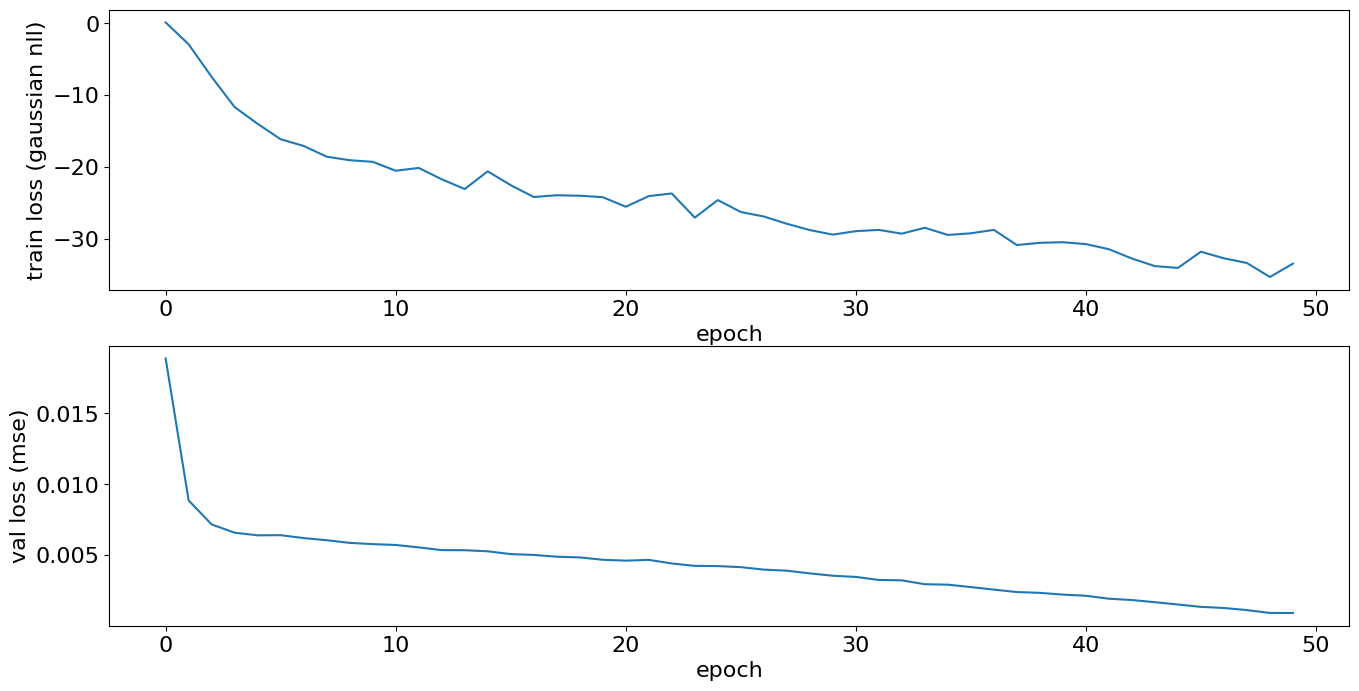

In [14]:
fig, ax = plt.subplots(2, 1, figsize=(16, 8))
ax[0].plot(train_losses)
ax[0].set_xlabel("epoch")
ax[0].set_ylabel("train loss (gaussian nll)")
ax[1].plot(val_losses)
ax[1].set_xlabel("epoch")
ax[1].set_ylabel("val loss (mse)")
plt.show()

## Prediction Accuracy

Initialize an one-step model

In [15]:
# Create a 1-D dynamics model for this environment
one_step_model = common_util.create_one_dim_tr_model(one_step_config, obs_shape, act_shape)

Train the one-step model

In [16]:
one_step_model_trainer = models.ModelTrainer(one_step_model, optim_lr=1e-4, weight_decay=5e-5)
one_step_train_dataset, one_step_val_dataset = common_util.get_basic_buffer_iterators(
    one_step_replay_buffer, #
    batch_size=cfg.overrides.model_batch_size,
    val_ratio=cfg.overrides.validation_ratio,
    ensemble_size=ensemble_size,
    shuffle_each_epoch=True
)
one_step_train_losses, one_step_val_losses = one_step_model_trainer.train(one_step_train_dataset, one_step_val_dataset,
                                               num_epochs=50, patience=100)

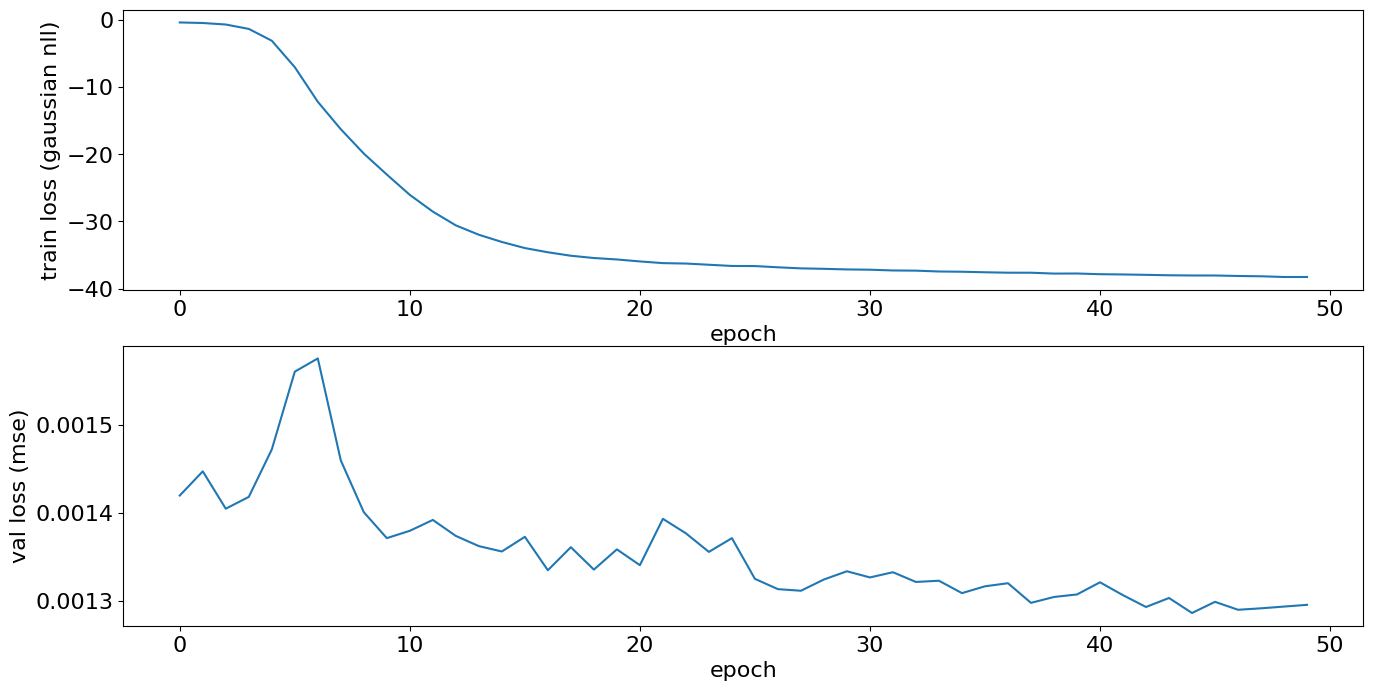

In [17]:
fig, ax = plt.subplots(2, 1, figsize=(16, 8))
ax[0].plot(one_step_train_losses)
ax[0].set_xlabel("epoch")
ax[0].set_ylabel("train loss (gaussian nll)")
ax[1].plot(one_step_val_losses)
ax[1].set_xlabel("epoch")
ax[1].set_ylabel("val loss (mse)")
plt.show()

Sample trajectories for evaluation, predict trajectories, and compute MSE across states (without batching, does not work for ensemble).  
This large block is mostly data handling! First, lets collate the data we need!

In [18]:
num_traj_eval = num_trials

# round trajectories to multiple of ensemble size for batching:
num_traj = int(ensemble_size * np.floor(num_traj_eval/ensemble_size))

# for storing data
eval_data_obs = []   # store observations for both prediction (initial state) and evaluation (full trajectory)
eval_data_act = []   # store plans here (for one-step model)
eval_traj_param = [] # store control parameters here for traj-based model

# collect trajectories from buffers
for i in range(num_traj):

    # base trajectory for computing accuracy
    traj = one_step_replay_buffer.sample_trajectory()
    traj_with_params = replay_buffer_traj_val.sample_trajectory() # doesn't have actions!

    # one-step data
    eval_data_obs.append(traj.obs)
    eval_data_act.append(traj.act)

    # traj-based data
    traj_with_params.act[:,-1] = np.arange(0,len(traj_with_params))+1
    eval_traj_param.append(traj_with_params.act)

# create array of state trajectories
true_states = np.stack(eval_data_obs)

Now we predict with the models! First we can pass the initial states and plans into the one-step model to unroll trajectories. Note that everything is stacked because the ensembles use batching.

In [19]:
def no_reward(act: torch.Tensor, next_obs: torch.Tensor) -> torch.Tensor:
    return torch.Tensor(0)

one_step_model_env = models.ModelEnv(env, one_step_model, termination_fns.no_termination, no_reward, generator=generator)


### rollout one-step model in batch of trajectories ###
states, _, _ = common_util.rollout_model_env(one_step_model_env,
                                 initial_obs=np.stack([o[0] for o in eval_data_obs],axis=0),
                                plan=np.stack(eval_data_act, axis=1))

We don't need a utility to predict with the trajectory-based model, but in that case we need to do some of the data processing that would be handled in the `mbrl.common_utils`.

In [42]:
# concatenare initial states with parameters + time index
obs_stack = np.stack([o[0] for o in eval_data_obs])
param_stack = np.stack(eval_traj_param)

param_dim = np.shape(param_stack)[-1]
obs_dim = np.shape(obs_stack)[-1]

# set up batching
param_expand = param_stack.reshape(-1,param_dim)
obs_expand = np.repeat(obs_stack[:, np.newaxis, :], trial_length, axis=1).reshape(-1,obs_dim)

# to torch
# 19 states concatenate 29 parameters, with 5000 instances
x_data = np.concatenate((obs_expand,param_expand), axis=1)
x_tensor = torch.from_numpy(x_data).float().to(device)

# normalize input data
x_tensor = dynamics_model.input_normalizer.normalize(x_tensor)


# predict trajectories
with torch.no_grad():
    states_pred, _ = dynamics_model(x_tensor)

In [45]:
print(x_tensor.shape)
print(obs_expand.shape)
print(param_expand.shape)

torch.Size([5000, 48])
(5000, 19)
(5000, 29)


In [29]:
print(eval_data_obs[2][1])

[-6.23334548e-04 -4.56347974e-04 -1.66427635e-03  1.24635512e-03
 -1.32096163e-03  7.68623431e-04  1.41440835e-02  0.00000000e+00
  1.29697815e-01 -1.60546824e-02 -1.65417383e-03 -4.14744467e-02
 -6.99876808e-03 -1.10435337e-01 -2.62607764e-02 -8.76318440e-02
 -1.51607348e-02  9.39169288e-01  0.00000000e+00]


Now let's analyze the data!

In [38]:
# Compute one-step errors
one_step_pred_states = np.swapaxes(states[:-1].squeeze(),0,1)
one_step_errors = np.mean((true_states - one_step_pred_states)**2, axis=-1)

# compute trajectory-based errors
# TypeError: can't convert cuda:0 device type tensor to numpy. Use Tensor.cpu() to copy the tensor to host memory first.

states_pred = states_pred.cpu().numpy().reshape(num_traj, trial_length, -1)
traj_based_errors = np.mean((true_states - states_pred)**2, axis=-1)

## Trajectory-based vs One-step
Here we take the errors and plot them over time!

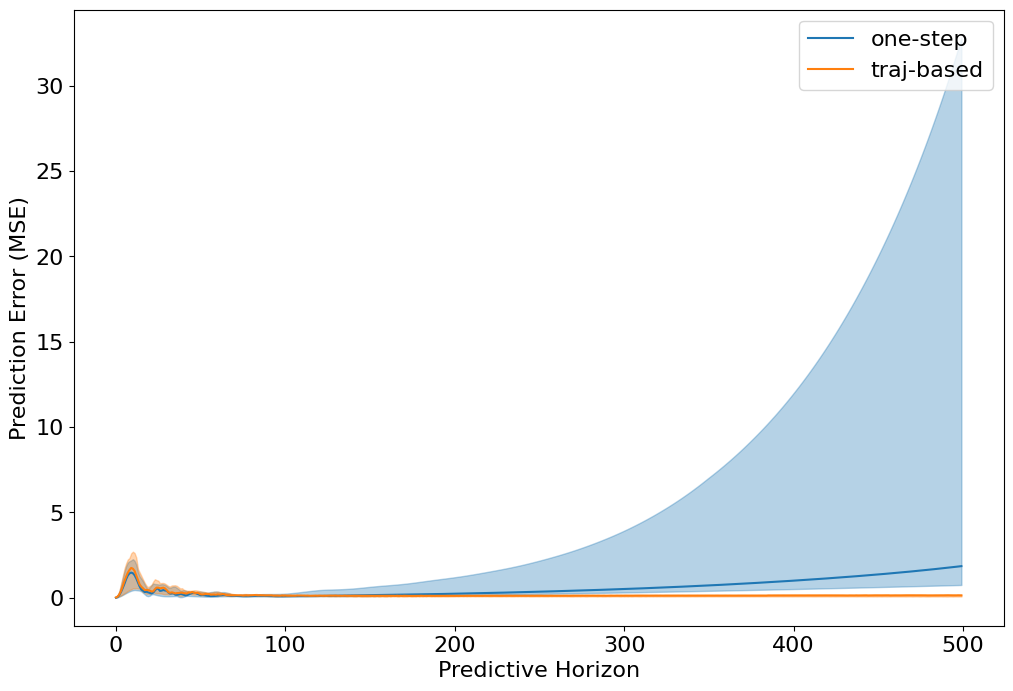

In [22]:
# cumulative_errors_os = np.stack(one_step).squeeze()
one_step_median = np.median(one_step_errors,axis=0)
one_step_90 = np.quantile(one_step_errors, .90, axis=0)
one_step_10 = np.quantile(one_step_errors, .10, axis=0)

# cumulative_errors_tb = np.stack(traj_based).squeeze()
traj_based_median = np.median(traj_based_errors,axis=0)
traj_based_90 = np.quantile(traj_based_errors, .90, axis=0)
traj_based_10 = np.quantile(traj_based_errors, .10, axis=0)


colors = ['#1f77b4',  # muted blue
          '#ff7f0e',  # safety orange
          '#2ca02c',  # cooked asparagus green
          '#d62728',  # brick red
          ]

fig, ax = plt.subplots(1, 1, figsize=(12, 8))
ax.plot(one_step_median, label="one-step", c=colors[0])
ax.plot(traj_based_median, label="traj-based", c=colors[1])
ax.fill_between(np.arange(len(one_step_median)), one_step_10, one_step_90, color=colors[0], alpha=.33)
ax.fill_between(np.arange(len(traj_based_median)), traj_based_10, traj_based_90, color=colors[1], alpha=.33)
ax.set_xlabel("Predictive Horizon")
ax.set_ylabel("Prediction Error (MSE)")
ax.legend()
plt.show()